# Neuronale Netze

## Überblick

Neuronale Netze sind relativ einfach strukturierte Modellfunktionen mit sehr vielen (teilweise auch redundanten) Parametern. Die Anpassung dieser Parameter führt zu 
hochdimensionalen, nicht-konvexen Optimierungsproblemen.

Anhand einfacher Beispiele wird das Verhalten von konventionellen bzw. stochastischen Gradienten-Verfahren untersucht. Außerdem werden beschleunigte Varianten betrachtet.

## Multi-Layer Perceptron (MLP)

Ein einfaches neuronales Netz das zur Bearbeitung von
Klassifikations- und Regressionsproblemen eingesetzt werden kann
ist das **Multi-Layer Perceptron** (MLP).
Bei beiden Problemklassen wird versucht mit Hilfe
eines Trainigsdatensatzes eine parameterabhängige Modellfunktion
\begin{equation*} 
g:\mathbb{R}^n \times \mathbb{R}^p \to \mathbb{R}^o,
\quad
x,w \mapsto g(x,w)
\end{equation*} 
anzupassen,
die die Inputs möglichst genau auf die Outputs abbildet.

Bei der linearen Regression haben wir
einen linear affinen Ansatz der Form
\begin{equation*} 
g(x, w) = G(x) w + c(x)
\end{equation*}
benutzt und dann die Parameter $w$
mit Hilfe der Trainingsdaten möglichst gut (bezüglich des benutzten Loss)
angepasst. Die dabei entstehenden Optimierungsprobleme
waren relativ einfach beherrschbar.

Beim MLP benutzt man einen anderen, allgemeineren
Ansatz für $g$. Wir betrachten hier den Fall, dass der Output
skalar ist, d.h. $g:\mathbb{R}^n\times \mathbb{R}^p  \to \mathbb{R}$.

![MLP, \url{http://scikit-learn.org/stable/modules/neural_networks_supervised.html}](DatenNotebooks/mlp.png)

Ein MLP hat dann folgende Struktur (Graphik von http://scikit-learn.org/stable/modules/neural_networks_supervised.html):

- der Input $X$ besteht aus den Komponenten 
  $X=(x_1,\ldots,x_n)$, sie bilden die **Input-Layer**
    
- Linearkombinationen der Form
  \begin{equation*} 
  u_i = w_{i0}^{(1)} +  w_{i1}^{(1)}x_1 + \cdots w_{in}^{(1)}x_n, \quad i = 1,\ldots, k
  \end{equation*}
  werden als Input für die "Neuronen"
  $a_1,\ldots, a_k$ der **Hidden-Layer** benutzt
  
- jedes Neuron $a_i$ wendet dann auf seinen skalaren Input $u_i$
  eine skalare Funktion $a:\mathbb{R}\to\mathbb{R}$, 
  die **Aktivierungsfunktion**, an, d.h. wir erhalten
  als Output der "Neuronen" $a_i$
  \begin{equation*} 
  v_i = a(u_i), \quad  i = 1,\ldots,k
  \end{equation*}
  
- der Output $g(x,w)$ wird schließlich als Linearkombination
  \begin{equation*} 
  g(x, w) = w_0^{(2)} +  w_{1}^{(2)} v_1 + \cdots w_{k}^{(2)} v_k
  \end{equation*}
  berechnet

$g$ ist also durch
\begin{equation*} 
\big(w_{ij}^{(1)} \big)_{\substack{i = 1,\ldots, k\\ j = 0,\ldots, n}},
\quad
\big(w_{j}^{(2)} \big)_{j = 0,\ldots, k}
\end{equation*}
parametriert, d.h. die Anzahl der Parameter ist hoch.
Da $a$ nichtlinear ist, ist $g$ auch nichtlinear.

Der Ansatz kann problemlos auf mehrere Hidden-Layers
sowie vektorwertige Zielfunktionen verallgemeinert werden.

Mit Hilfe des Trainingsdatensatzes werden die Parameter $w$
von $g$ so bestimmt, dass der Loss minimiert wird. 
Die dabei auftretenden Optimierungsprobleme sind i.d.R.
nicht konvex und werden üblicherweise mit Varianten
des [Gradientenverfahrens](https://de.wikipedia.org/wiki/Gradientenverfahren) 
näherungsweise gelöst.

Für die Berechnung der dabei benötigten Ableitungen nach den Parametern $w$ gibt es effiziente Methoden ([Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)).

## Modellproblem 1-Neuron-MLP

Um ein Gefühl für das Trainingsverhalten eines Netzes zu bekommen, betrachten
wir ein triviales Netz mit einem skalaren Input, einem skalaren Output,
einer Schicht mit einem Neuron und Aktivierungsfunktion 
$r(x) = \max(0, x)$ 
(**RELU**, **Re**ctified **L**inear **U**nit), d.h.
\begin{equation*} 
g(x, w) = r(w_1 \, x + w_2)\,w_3 + w_4,
\quad
r(x) = \max(0, x).
\end{equation*}
Als Trainingsdatensatz wird
\begin{equation*} 
x_i = y_i = \frac{i}{n}, \quad i = 0,\ldots,n, \quad n=10
\end{equation*}
benutzt. 

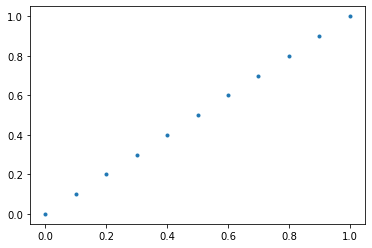

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import copy

seed = 123

%matplotlib inline


## Parameter festlegen

# Anzahl Neuronen
nn = 1

# Anzahl Trainingssample
ntrain = 11

a =  0
b =  1

# Anzahl Plotpunkte
nplot = 1000
Xplot = np.linspace(a-0.25, b+0.25, nplot).reshape(-1,1)


## Daten erzeugen
np.random.seed(seed)

#g = lambda x: np.sin(10*x*x)
g = lambda x: x

Xtrain = np.linspace(a, b, ntrain).reshape(-1,1)
#Xtrain = (np.random.rand(ntrain) * (b - a) + a).reshape(-1,1)
Xtrain.sort(axis=0)

ytrain = g(Xtrain)#.ravel()
#ytrain = ytrain + 0.1 * np.random.randn(*ytrain.shape)

plt.plot(Xtrain, ytrain, '.');

Die Parameter $w$ sollen so bestimmt werden, dass
\begin{equation*} 
    l(w) = \frac{1}{n} \sum_{i=1}^n \big(g(x_i, w) -y_i\big)^2
\end{equation*}
minimiert wird.
Da $g$ nichtlinear in $w$ ist, ist auch $f$ nichtlinear.

Für die Parameter $\hat{w} = (1, 0, 1, 0)^T$ erhalten wir
\begin{equation*} 
g(x,\hat{w}) = r(x) = \max(0,x),
\end{equation*}
d.h. $g(x,\hat{w})$ interpoliert die Daten $x_i, y_i$ exakt.
Damit ist
\begin{equation*} 
l(\hat{w}) = 0
\end{equation*}
und $\hat{w}$ globales Minimum von $l$.

Andererseits gilt für $\alpha > 0$
\begin{equation*} 
r(\alpha x) = \max(0, \alpha x) = \alpha \max(0, x) = \alpha r(x)
\end{equation*}
dass auch 
\begin{equation*} 
\hat{w}_\alpha = \big(\alpha, 0, \frac{1}{\alpha}, 0\big), \quad \forall \alpha > 0
\end{equation*} 
ein globales Minimum von $l$ ist und analog auch
\begin{equation*} 
\hat{w}_\beta = \big(1, \beta, 1, -\beta \big), \quad \forall \beta > 0.
\end{equation*} 

Damit kann $l$ nicht strikt konvex sein. Wie das folgende Beispiel zeigt ist $l$ nicht einmal konvex.

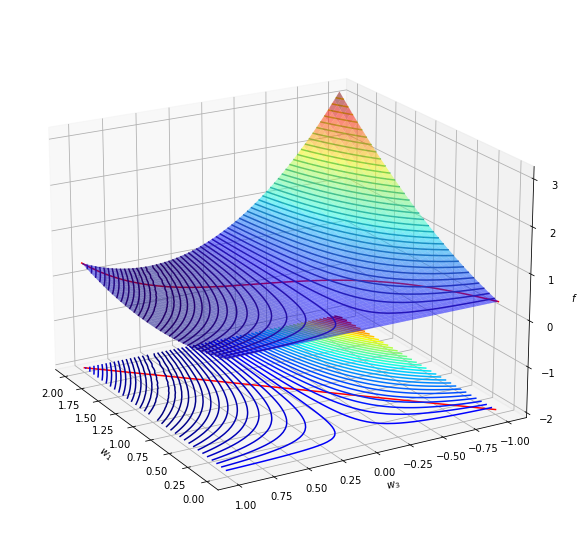

In [2]:
#%matplotlib notebook 
%matplotlib inline 

relu = lambda x : np.maximum(0, x)

def l(w1, w3):
    fw = 0.0
    for x,y in zip(Xtrain, ytrain):
        fw += (relu(w1 * x) * w3 - y)**2
    return fw/Xtrain.shape[0]

l = np.vectorize(l)


from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize = (10, 10))
plt.axes(projection='3d')

w1 = np.array([ 0, 2])
w3 = np.array([-1, 1])

#w1 = np.array([ 0, 1])
#w3 = np.array([-1, 0])

g1 = np.linspace(*w1)
g3 = np.linspace(*w3)

ww3, ww1 = np.meshgrid(g3, g1)
ww1 = ww1.T
ww3 = ww3.T
ff = l(ww1, ww3)

ax = plt.gca()
ax.plot_surface(ww1, ww3, ff, alpha = 0.5, cmap=plt.cm.jet)
cc = ff.max() * np.linspace(0,1)**2
#cc = 10*np.linspace(0,1)**5
ax.contour(ww1, ww3, ff, cc)

zoff = -2
ax.contour(ww1, ww3, ff, cc, zdir='z', offset=zoff, cmap=plt.cm.jet)
#plt.contour(ww1, ww3, f(ww1, ww3), zdir='x', cmap = plt.cm.jet);

l1 = np.linspace(*w1)
l3 = np.linspace(*w3)
ax.plot3D(l1, l3, l(l1, l3), c = 'r')

l1 = np.linspace(*w1, 2)
l3 = np.linspace(*w3, 2)
ax.plot3D(l1, l3, zoff * np.ones(l1.shape), 'r')

ax.set_zlim(zoff, ff.max())
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_3$')
ax.set_zlabel('$f$')
ax.view_init(20, 150)

Für $w_2 = w_4 = 0$ sind die Funktionswerte entlang der
Strecke $(w_1,w_3) = (0,-1)$ nach $(w_1,w_3) = (2,1)$ dargestellt.

Die fehlende Konvexität wird uns beim Anpassen der Parameter $w$ noch viel "Freude" bereiten.

Diese Anpassung werden wir nun mit 3 der gängigsten Software Tools vornehmen.

### Scikit-Learn

Wir passen einen `MLPRegressor` an und benutzen die Default-Einstellungen.

solver = adam, score = -0.19949628496033456


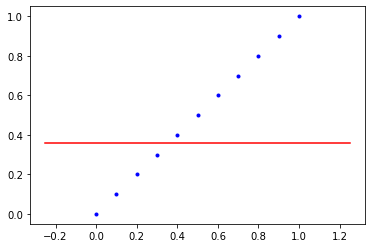

In [3]:
from sklearn import neural_network

mlp = neural_network.MLPRegressor(hidden_layer_sizes = [nn], max_iter = 10000, random_state = seed)
mlp.fit(Xtrain, ytrain.flat)

def ev(mlp, c = 'r', label=''):
    plt.plot(Xtrain, ytrain, 'b.');
    plt.plot(Xplot, mlp.predict(Xplot), c, label=label);
    print("solver = {}, score = {}".format(mlp.solver, mlp.score(Xtrain, ytrain)))

ev(mlp)

Das Ergebnis ist unbrauchbar.

Der Startwert für den iterativen Löser wird zufällig gewählt und kann
über den Parameter `random_state` beeinflusst werden

solver = adam, score = -0.5531367823099405


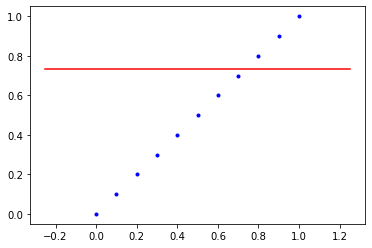

In [4]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes = [nn], max_iter = 10000, random_state = 234)
mlp.fit(Xtrain, ytrain.flat)
ev(mlp)

solver = adam, score = 0.866475209637087


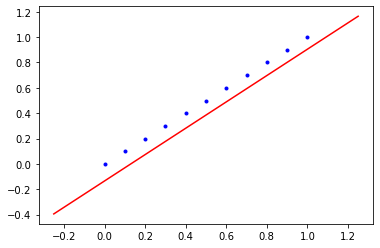

In [5]:
mlp = neural_network.MLPRegressor(hidden_layer_sizes = [nn], max_iter = 10000, random_state = 314159)
mlp.fit(Xtrain, ytrain.flat)
ev(mlp)

Die Ergebnisse hängen offensichtlich extrem stark vom Startwert ab. Die Qualität ist insgesamt sehr dürftig.

### Keras-Tensorflow

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential(
[
 Dense(units = nn, input_dim = 1),
 #Dense(units = nn, input_dim = 1, kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=seed)),
 Activation('relu'),
 #Activation('tanh'),
 Dense(units = 1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 235ms/step - loss: 0.1085 - accuracy: 0.0909
loss = 0.10846421867609024


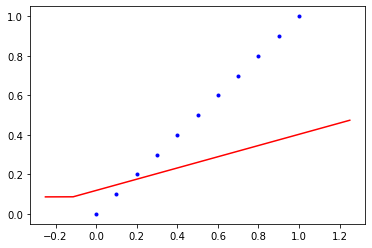

In [7]:
model.compile(loss='mse',
              optimizer='nadam',
              metrics=['accuracy'])

model.fit(Xtrain, ytrain, epochs = 100, verbose = 0);

def kev(model, c = 'r'):
    plt.plot(Xtrain, g(Xtrain), 'b.');
    plt.plot(Xplot, model.predict(Xplot), c);
    print("loss = {}".format(model.evaluate(Xtrain, ytrain)[0]))
    
kev(model)    

### Pytorch

In [8]:
import torch
import torch.nn as tnn

xt = torch.from_numpy(Xtrain).to(torch.float32)
yt = torch.from_numpy(ytrain).to(torch.float32)

from torch.utils.data import TensorDataset, DataLoader

dst = TensorDataset(xt, yt)
dlt = DataLoader(dst, batch_size = 5, shuffle=True)

class Percep(tnn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = tnn.Linear(1, nn)
        self.act1    = tnn.ReLU() 
        self.linear2 = tnn.Linear(nn, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

model = Percep()

model.eval()

Percep(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=1, out_features=1, bias=True)
)

Training loss:  tensor(1.3062, grad_fn=<MseLossBackward>)


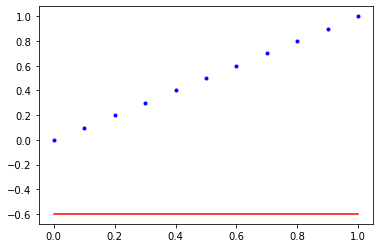

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

import torch.nn.functional as F
loss_fn = F.mse_loss

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in dlt:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(xt), yt))

fit(100, model, loss_fn, opt)

def pev(model, c = 'r'):
    plt.plot(Xtrain, g(Xtrain), 'b.');
    plt.plot(xt.data.numpy(), model(xt).data.numpy(), 'r');

pev(model)

## (Sub)Gradient-Descent

Wir betrachten wieder unser triviales Netz von oben
\begin{equation*} 
g(x, w) = r(w_1 \, x + w_2)\,w_3 + w_4,
\quad
r(x) = \max(0, x),
\end{equation*}
mit Trainingsdatensatz
\begin{equation*} 
x_i = y_i = \frac{i}{n}, \quad i = 0,\ldots,n, \quad n=10.
\end{equation*}

Da $r$ bei $0$ nicht differenzierbar ist, ist eine direkte Anwendung des Gradientenverfahrens zunächst nicht möglich.

Man kann dies durch zwei Strategien reparieren:

- man ersetzt $r$ durch eine differenzierbare Approximation $\tilde{r}$

- man benutzt statt dem Gradienten den Subgradienten

Wir benutzen die zweite Variante. Als Subgradient von $r$ erhalten wir
\begin{equation*} 
\partial r(x)=
\begin{cases}
0 & x < 0\\
[0,1] & x = 0\\
1 & 0< x
\end{cases},
\end{equation*}
d.h. bei $x=0$ müssen wir uns für einen Wert in $[0,1]$ entscheiden.
Wie wir später sehen werden, haben wir hier "freie Auswahl".
Der Einfachheit halber benutzen wir den Wert $\frac{1}{2}$.

In [10]:
import autograd.numpy as np
from autograd import grad

relu = lambda x : np.maximum(0, x)

relu1 = grad(relu)
relu1(-1.0), relu1(0.0), relu1(1.0)

(0.0, 0.5, 1.0)

Für verschieden Anfangswerte erhalten wir

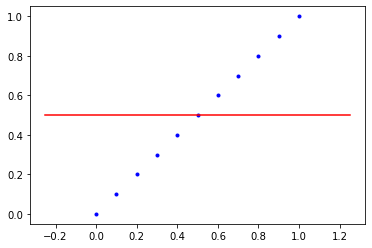

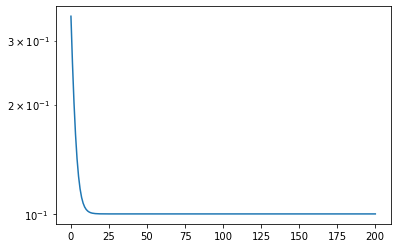

In [11]:
g = lambda x,w : relu(w[0] * x + w[1]) * w[2] + w[3]

def l(w):
    fw = 0.0
    for x,y in zip(Xtrain, ytrain):
        fw += (g(x,w) - y)**2
    return fw[0] / Xtrain.shape[0]

l1 = grad(l)

def GD(w0, l1, lr = 1e-1, nit = 100):
    w = w0.copy()
    ww = [w]
    for k in range(nit):
        w = w - lr * l1(w)
        ww.append(w)
    return ww

def ev(w, c = 'r', label=''):
    plt.plot(Xtrain, ytrain, 'b.');
    plt.plot(Xplot, g(Xplot, w[-1]), c);
    plt.figure()
    plt.semilogy(list(map(l, w)), label=label)
    #plt.ylabel('$l$',rotation=0)

w0 = np.zeros(4)
w = GD(w0, l1, 0.1, 200)
ev(w)

bzw.

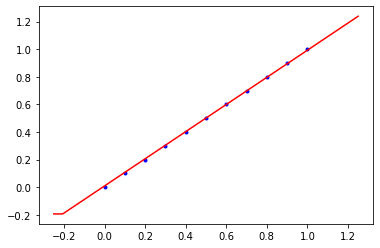

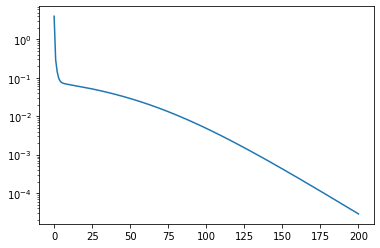

In [12]:
w0 = np.ones(4)
w = GD(w0, l1, 0.1, 200)
ev(w)

## Accelerated Gradient-Descent (Nesterov)

Durch eine einfache Modifikation kann man das (Sub)Gradientenverfahren
beschleunigen. 
Man bestimmt die neue Suchrichtung als Kombination aus dem aktuellen
negativen Gradienten und der vorherigen Suchrichtung (ähnlich wie beim
CG-Verfahren).

Die bekannteste Variante stammt von [Nesterov](https://uclouvain.be/fr/repertoires/yurii.nesterov), der auch nachgewiesen hat, dass diese Verfahren in einem
gewissen Sinn optimal sind.
Die Iterationsvorschrift sieht wie folgt aus:
\begin{align*}
 w^{(-1)} &= w^{(0)} \text {gegeben}\\
 k = 1&,2,...\\
     & v^{(k)} = w^{(k-1)} + \frac{k-2}{k+1} \big( w^{(k-1)} - w^{(k-2)} \big) \\
     & w^{(k)} = v^{(k)} - \alpha^{(k)} l'(v^{(k)})
\end{align*}

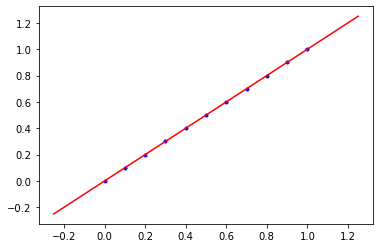

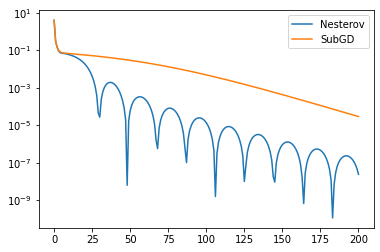

In [13]:
def Nes(w0, l1, lr = 0.1, maxit = 30):
    # Variante von Tibshirani
    w = [w0, w0]
    
    for k in range(1,maxit+1):
        vk = w[-1] + (k-2)/(k+1) * (w[-1] - w[-2])
        wk = vk - lr * l1(vk)

        w.append(wk)

    return(w[1:])

w0 = np.ones(4)
wnes = Nes(w0, l1, 0.1, 200)
ev(wnes, label='Nesterov')
plt.semilogy(list(map(l, w)), label="SubGD")
plt.legend();

## Stochastic (Sub)Gradient-Descent

Wir betrachten noch einmal unsere Zielfunktion $l$
\begin{align*} 
l(w) 
&= \frac{1}{n} \sum_{i=1}^n \big(g(x_i, w) -y_i\big)^2
= \frac{1}{n} \sum_{i=1}^n l_i(w),
\\
l_i(w) &= \big(g(x_i, w) -y_i\big)^2.
\end{align*}
In jedem Schritt des (Sub)Gradienten-Verfahren muss
\begin{equation*} 
\partial l(w) = \frac{1}{n} \sum_{i=1}^n \partial l_i(w)
\end{equation*}
berechnet werden, d.h. der Aufwand skaliert mit der Anzahl
$n$ an Trainingsdaten, die zur Bestimmung der Parameter $w$
benutzt werden.

Andererseits ist $\partial l(w)$ offensichtlich der Mittelwert der einzelnen $\partial l_i(w)$, so dass es naheliegend ist, diesen Mittelwert durch eine weniger aufwendige Approximation zu nähern, z.B.:

- $\partial l(w) \approx \partial l_{\hat{i}}(w)$ für *ein* $\hat{i}\in \{1,\ldots,n\}$

- $\partial l(w) \approx \frac{1}{n_B} \sum_{i\in B} \partial l_i(w)$ für eine $n_B$-elementige Teilmenge $B \subset \{1,\ldots,n\}$ mit $n_B \le n$

Den Index $\hat{i}$ bzw. die Teilmenge $B$ wird in jedem Schritt des Gradienten-Verfahrens zufällig neu bestimmt. Das resultierende Verfahren heißt  Stochastic Gradient-Descent- bzw.
Minibatch Stochastic Gradient-Descent-Verfahren.

Angewandt auf unser Modellproblem erhalten wir mit $n_B = 1$

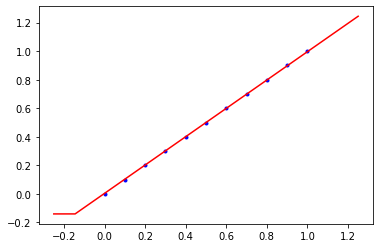

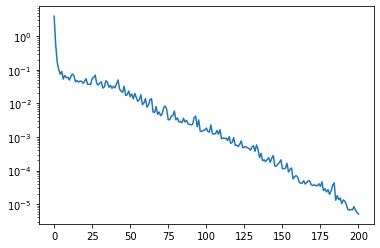

In [14]:
li = lambda w, x, y : ((g(x,w) - y)**2)[0]
li1 = grad(li)

def SGD(w0, li1, x, y, lr = 1e-1, nit = 100, bs = 1):
    w = w0.copy()
    ww = [w]
    for k in range(nit):
        g = 0.0
        for i in np.random.permutation(x.shape[0])[:bs]:
            g += li1(w, x[i], y[i])
        g /= bs
        w = w - lr * g
        ww.append(w)
    return ww

np.random.seed(seed)
w0 = np.ones(4)
w = SGD(w0, li1, Xtrain, ytrain, 0.1, 200)
ev(w)

Der Abfall der Loss-Funktion ist ähnlich schnell wie beim Standard-Gradienten-Verfahren, aber nicht monoton ("Rauschen")

Bei $n$ Training-Samples $x_i,y_i$ ist der Aufwand bei SGD pro Iteration
um einen Faktor $n$ kleiner.

Für $n_B = 3$ folgt

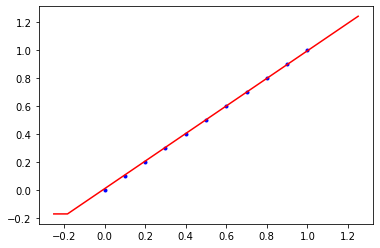

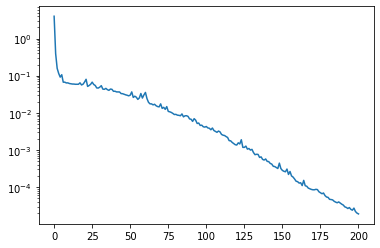

In [15]:
np.random.seed(seed)
w0 = np.ones(4)
wb = SGD(w0, li1, Xtrain, ytrain, 0.1, 200, bs = 3)
ev(wb)

Hier ist der Verlauf der Abfall der Loss-Werte etwas weniger "zitterig" als im Fall $n_B=1$, allerdings ist der Aufwand pro Iteration auch wesentlich höher.

Analog kann man auch für das Nesterov-Verfahren eine stochastische Variante
aufbauen.

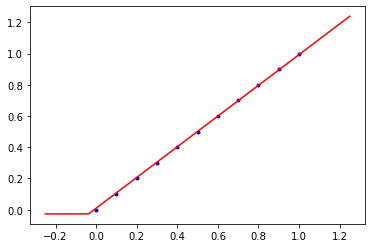

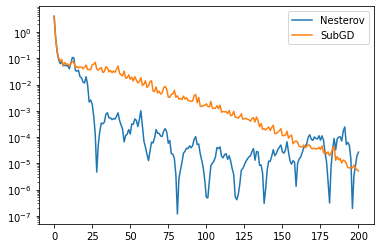

In [16]:
def SNes(w0, li1, x, y, lr = 0.1, maxit = 30, bs = 1):
    # Variante von Tibshirani
    w = [w0, w0]
    
    for k in range(1,maxit+1):
        vk = w[-1] + (k-2)/(k+1) * (w[-1] - w[-2])

        gk = 0.0
        for i in np.random.permutation(x.shape[0])[:bs]:
            gk += li1(vk, x[i], y[i])
        
        wk = vk - lr * gk

        w.append(wk)

    return(w[1:])

np.random.seed(seed)
w0 = np.ones(4)
wnes = SNes(w0, li1, Xtrain, ytrain, 0.1, 200)
ev(wnes, label='Nesterov')
plt.semilogy(list(map(l, w)), label="SubGD")
plt.legend();

## Backpropagation

Zuletzt muss noch überlegt werden, wie die (Sub)Gradienten
\begin{equation*} 
\partial l_i(w),
\quad 
l_i(w) = \big(g(x_i, w) -y_i\big)^2
\end{equation*}
möglichst effizient berechnet werden können.
Dadurch dass beim MLP die Parameter $w$ sehr komplex
in $g$ eingehen, ist dies nicht trivial.

Wir betrachten zunächst den trivialen Fall eines einzelnen skalaren Neurons.
Zur Vereinfachung der Notation wird der Index $i$ weg gelassen.
\begin{equation*} 
x \rightarrow w_1 x =\colon i_1  \rightarrow a(i_1) =\colon o_1 
\end{equation*}
mit differenzierbarem Loss $l$.
Für den Gradienten von $l$ nach $w_1$ erhalten wir
\begin{equation*} 
\partial_{w_1} l(o_1)
= l'(o_1)\partial_{w_1} o_1
= l'(o_1)a'(i_1)\partial_{w_1} i_1
= l'(o_1)a'(i_1)  x
\end{equation*}
Hat man $o_1$ berechnet, so kennt man auch $i_1$ und $\partial_{w_1} l(o_1)$ ist direkt bestimmbar.

Betrachten wir nun die analoge Konstellation für zwei Neuronen
\begin{equation*} 
x 
\rightarrow w_1 x =\colon i_1  \rightarrow a(i_1) =\colon o_1 
\rightarrow w_2 o_1 =\colon i_2  \rightarrow a(i_2) =\colon o_2. 
\end{equation*}
Für die Ableitung von $l(o_2)$ nach $w_k$ erhalten wir
\begin{equation*} 
\partial_{w_k} l(o_2) 
= l'(o_2)\partial_{w_k} o_2 
= l'(o_2)a'(i_2)\partial_{w_k} i_2
= l'(o_2)a'(i_2)\partial_{w_k} (w_2 o_1) 
\end{equation*}
Für $w_2$ gilt dann
\begin{equation*} 
\partial_{w_2} l(o_2)
= l'(o_2)a'(i_2)\partial_{w_2} (w_2 o_1) 
= l'(o_2)a'(i_2) \big(o_1 + w_2 \partial_{w_2} o_1 \big)
\end{equation*}
und da $o_1$ nicht von $w_2$ abhängt folgt
\begin{equation*} 
\partial_{w_2} l(o_2) = l'(o_2)a'(i_2)  o_1,
\end{equation*}
d.h. $\partial_{w_2} l(o_2)$ kann einfach bestimmt werden.

Für  $\partial_{w_1} l(o_2)$ erhalten wir 
\begin{equation*} 
\partial_{w_1} l(o_2)
= l'(o_2)a'(i_2)\partial_{w_1} (w_2 o_1) 
= l'(o_2)a'(i_2)  w_2 \partial_{w_1} o_1
\end{equation*}
und mit $\partial_{w_1} o_1 = a'(i_1)\partial_{w_1} i_1 = a'(i_1) x$ folgt
\begin{equation*} 
\partial_{w_1} l(o_2) = l'(o_2)a'(i_2)  w_2 a'(i_1) x
\end{equation*}

Analog kann man auch bei komplexeren Netzen beginnend von der Output-Seite hin zur Input-Seite Schritt für Schritt die Ableitungen nach von $l_i$ nach den Parametern der jeweiligen
Schicht generieren. Deshalb heißt dieser Zugang *Backpropagation*.

## Zusammenfassung

Die Parameteranpassung bei neuronalen Netzen ist schwierig, da
die Zielfunktion oft nicht differenzierbar (z.B. RELU Aktivierung $a(x)=\max(0,x)$)
bzw. nicht konvex ist, so dass die Ergebnisse von gradientenartigen Verfahren sehr stark von der Wahl des Anfangswertes abhängen (Nebenminima).

Besonders populär sind stochastische Gradienten-Verfahren, die auch bei großen Trainings-Datensätzen sehr effizient sind. Die benötigten Ableitungen werden dabei in der Regel mit
Backpropagation berechnet.

Man beachte den Unterschied zwischen SGD und Coordinate-Descent. Mit beiden Verfahren minimiert man die Zielfunktion
\begin{equation*} 
l(w) = \frac{1}{n} \sum_{i=1}^n l_i(w),
\quad
l_i(w) = \big(g(x_i, w) -y_i\big)^2
\end{equation*}
durch approximative Gradienten-Updates
\begin{equation*} 
w^{(k+1)} = w^{(k)} - \alpha^{(k)} g^{(k)}
\end{equation*}
mit
\begin{equation*} 
g_{SGD}^{(k)} = \partial_w l_{\hat{i}}(w)
\end{equation*}
bzw.
\begin{equation*} 
g_{CD}^{(k)} = \partial_{w_{\hat{i}}} l(w).
\end{equation*}